Data loaded successfully.
Dataset shape: (8782, 33)

Distribution of the new 'peak_category_daily' target:
peak_category_daily
Shoulder    4384
Peak        2207
Off-Peak    2191
Name: count, dtype: int64

Shape of processed features: (8782, 26). The data is ready for modeling.

--- BUILDING MODEL 1: 'is_jam' CLASSIFIER ---
Balancing 'is_jam' training data with SMOTE...


C:\Users\syahm\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\syahm\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


is_jam
False    5620
True     5620
Name: count, dtype: int64
Training 'is_jam' model...

--- 'is_jam' Model Evaluation ---
Accuracy: 0.8480

Classification Report:
              precision    recall  f1-score   support

   Not a Jam       0.89      0.92      0.91      1405
         Jam       0.63      0.57      0.60       352

    accuracy                           0.85      1757
   macro avg       0.76      0.74      0.75      1757
weighted avg       0.84      0.85      0.84      1757



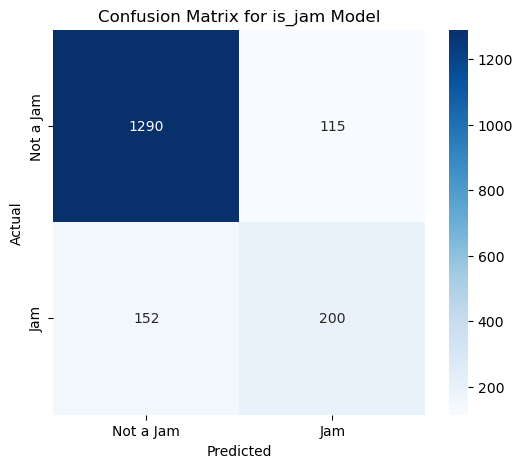



--- BUILDING MODEL 2: 'peak_category_daily' CLASSIFIER ---
Balancing 'peak_category_daily' training data with SMOTE...
peak_category_daily
Shoulder    3507
Peak        3507
Off-Peak    3507
Name: count, dtype: int64
Training 'peak_category_daily' model...


C:\Users\syahm\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\syahm\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



--- 'peak_category_daily' Model Evaluation ---
Accuracy: 0.6397

Classification Report:
              precision    recall  f1-score   support

    Off-Peak       0.72      0.66      0.69       438
        Peak       0.53      0.47      0.50       442
    Shoulder       0.65      0.71      0.68       877

    accuracy                           0.64      1757
   macro avg       0.63      0.62      0.62      1757
weighted avg       0.64      0.64      0.64      1757



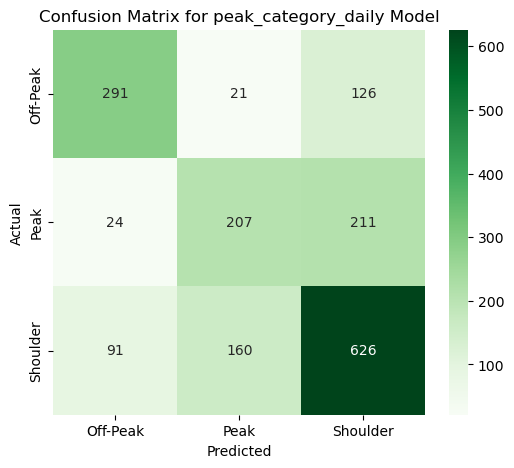



--- FEATURE IMPORTANCE ANALYSIS (from 'is_jam' model) ---
Top 10 Most Important Features for Predicting Jams:

                 feature  importance
6              month_cos    0.153807
5              month_sin    0.152053
4               hour_cos    0.147643
3               hour_sin    0.104203
2          windspeed_10m    0.089014
0         temperature_2m    0.088688
1   relative_humidity_2m    0.085518
17         weathercode_3    0.016965
11  day_of_week_Thursday    0.016444
18        weathercode_51    0.015212


C:\Users\syahm\AppData\Local\Temp\ipykernel_4072\1544337523.py:215: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importances.head(15), palette='viridis')


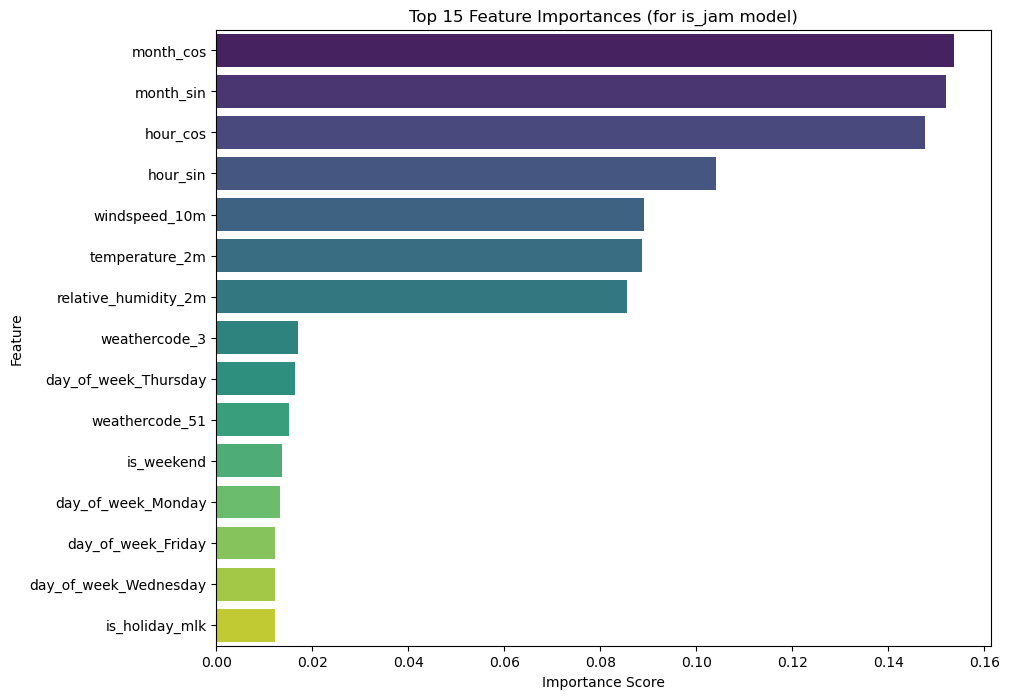

In [1]:
# ==============================================================================
# 1. SETUP AND DATA LOADING
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset prepared during EDA
df = pd.read_csv("traffic_with_weather_modified.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

print("Data loaded successfully.")
print(f"Dataset shape: {df.shape}")


# ==============================================================================
# 2. ADVANCED FEATURE & TARGET ENGINEERING
# ==============================================================================
# This section is crucial to create a meaningful target for the peak category model

def assign_daily_peak_category(day_group):
    """
    Assigns Peak/Off-Peak/Shoulder labels based on each day's specific traffic quantiles.
    This creates a more robust target variable than a global definition.
    """
    peak_threshold = day_group['total_traffic'].quantile(0.75)  # Top 25% are Peak
    off_peak_threshold = day_group['total_traffic'].quantile(0.25) # Bottom 25% are Off-Peak
    
    conditions = [
        day_group['total_traffic'] >= peak_threshold,
        day_group['total_traffic'] < off_peak_threshold
    ]
    choices = ['Peak', 'Off-Peak']
    
    day_group['peak_category_daily'] = np.select(conditions, choices, default='Shoulder')
    return day_group

# Apply the function to each day in the dataset
df = df.groupby(df['datetime'].dt.date, group_keys=False).apply(assign_daily_peak_category)

print("\nDistribution of the new 'peak_category_daily' target:")
print(df['peak_category_daily'].value_counts())


# ==============================================================================
# 3. PRE-MODELING: FEATURE SELECTION & PREPROCESSING
# ==============================================================================

# Define the features (X) to be used for BOTH models.
# These are independent predictors that don't cause data leakage.
features_to_use = [
    'temperature_2m', 
    'relative_humidity_2m', 
    'weathercode', 
    'windspeed_10m',
    'is_weekend', 
    'hour', 
    'is_holiday_mlk',
    'day_of_week',
    'month'
]

# Use .copy() to avoid the SettingWithCopyWarning
X = df[features_to_use].copy() 

# --- Create Cyclical Features for Time ---
X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)

month_map = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 
             'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
X['month_num'] = X['month'].map(month_map)

X['month_sin'] = np.sin(2 * np.pi * X['month_num'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month_num'] / 12)

# Drop the original columns that are now encoded
X = X.drop(['hour', 'month', 'month_num'], axis=1)

# --- Define Preprocessing Steps ---
categorical_features = ['day_of_week', 'weathercode']
numerical_features = [
    'temperature_2m', 'relative_humidity_2m', 'windspeed_10m', 
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Apply preprocessing to create the final feature set
X_processed = preprocessor.fit_transform(X)

print(f"\nShape of processed features: {X_processed.shape}. The data is ready for modeling.")


# ==============================================================================
# 4. MODEL 1: PREDICTING TRAFFIC JAMS (is_jam)
# ==============================================================================
print("\n--- BUILDING MODEL 1: 'is_jam' CLASSIFIER ---")

# --- Define Target and Split Data ---
y_jam = df['is_jam']
X_train_jam, X_test_jam, y_train_jam, y_test_jam = train_test_split(
    X_processed, y_jam, test_size=0.2, random_state=42, stratify=y_jam
)

# --- Apply SMOTE to balance the training data ---
print("Balancing 'is_jam' training data with SMOTE...")
smote_jam = SMOTE(random_state=42)
X_train_resampled_jam, y_train_resampled_jam = smote_jam.fit_resample(X_train_jam, y_train_jam)
print(y_train_resampled_jam.value_counts())

# --- Train the Random Forest Model ---
rf_jam = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Training 'is_jam' model...")
rf_jam.fit(X_train_resampled_jam, y_train_resampled_jam)

# --- Evaluate the Model ---
y_pred_jam = rf_jam.predict(X_test_jam)
print("\n--- 'is_jam' Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test_jam, y_pred_jam):.4f}\n")
print("Classification Report:")
print(classification_report(y_test_jam, y_pred_jam, target_names=['Not a Jam', 'Jam']))

# Confusion Matrix
cm_jam = confusion_matrix(y_test_jam, y_pred_jam)
plt.figure(figsize=(6,5))
sns.heatmap(cm_jam, annot=True, fmt='d', cmap='Blues', xticklabels=['Not a Jam', 'Jam'], yticklabels=['Not a Jam', 'Jam'])
plt.title('Confusion Matrix for is_jam Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# ==============================================================================
# 5. MODEL 2: PREDICTING PEAK CATEGORY (peak_category_daily)
# ==============================================================================
print("\n\n--- BUILDING MODEL 2: 'peak_category_daily' CLASSIFIER ---")

# --- Define Target and Split Data ---
y_peak = df['peak_category_daily']
X_train_peak, X_test_peak, y_train_peak, y_test_peak = train_test_split(
    X_processed, y_peak, test_size=0.2, random_state=42, stratify=y_peak
)

# --- Apply SMOTE to balance the training data ---
print("Balancing 'peak_category_daily' training data with SMOTE...")
smote_peak = SMOTE(random_state=42)
X_train_resampled_peak, y_train_resampled_peak = smote_peak.fit_resample(X_train_peak, y_train_peak)
print(y_train_resampled_peak.value_counts())

# --- Train the Random Forest Model ---
rf_peak = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Training 'peak_category_daily' model...")
rf_peak.fit(X_train_resampled_peak, y_train_resampled_peak)

# --- Evaluate the Model ---
y_pred_peak = rf_peak.predict(X_test_peak)
class_names = sorted(df['peak_category_daily'].unique()) # Get class names in alphabetical order for report
print("\n--- 'peak_category_daily' Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test_peak, y_pred_peak):.4f}\n")
print("Classification Report:")
print(classification_report(y_test_peak, y_pred_peak, labels=class_names))

# Confusion Matrix
cm_peak = confusion_matrix(y_test_peak, y_pred_peak, labels=class_names)
plt.figure(figsize=(6,5))
sns.heatmap(cm_peak, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for peak_category_daily Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# ==============================================================================
# 6. FEATURE IMPORTANCE ANALYSIS (using the 'is_jam' model)
# ==============================================================================
print("\n\n--- FEATURE IMPORTANCE ANALYSIS (from 'is_jam' model) ---")

# Get feature names from the preprocessor to match the model's input
try:
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
except AttributeError:
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)

# Combine all feature names in the correct order
boolean_features_left_over = ['is_weekend', 'is_holiday_mlk'] # From 'remainder=passthrough'
all_feature_names = numerical_features + list(cat_feature_names) + boolean_features_left_over

# Create a DataFrame for Feature Importances
importances = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_jam.feature_importances_
}).sort_values('importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Most Important Features for Predicting Jams:\n")
print(importances.head(10))

# Plot the Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importances.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (for is_jam model)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [3]:
# ==============================================================================
# 7. GENERATE PREDICTIONS FOR THE ENTIRE DATASET (for Power BI Dashboard)
# ==============================================================================
print("\n\n--- Generating final predictions for the dashboard ---")

# We already have our fully preprocessed feature set 'X_processed' from earlier.
# This contains the correct features for every row in our original 'df'.

# --- Predict 'is_jam' for every row ---
# Use the trained 'rf_jam' model
jam_predictions = rf_jam.predict(X_processed)

# --- Predict 'peak_category_daily' for every row ---
# Use the trained 'rf_peak' model
peak_predictions = rf_peak.predict(X_processed)


# --- Create a new DataFrame for the dashboard ---
# Start with a copy of your original dataframe to keep all original columns
dashboard_df = df.copy()

# Add the new prediction columns
dashboard_df['predicted_jam'] = jam_predictions
dashboard_df['predicted_peak_category'] = peak_predictions

# Convert boolean 'predicted_jam' to a more user-friendly string
dashboard_df['predicted_jam_label'] = dashboard_df['predicted_jam'].apply(lambda x: 'Jam Likely' if x else 'No Jam')


# --- Select and reorder columns for the final export ---
# This makes the final file clean and easy to use in Power BI
final_columns = [
    # Identifiers
    'datetime',
    'hour',
    'day_of_week',
    'month',
    'is_weekend',
    'is_holiday_mlk',
    
    # Original Weather Data
    'temperature_2m',
    'relative_humidity_2m',
    'weathercode',
    'windspeed_10m',
    
    # Original Traffic Data (useful for context)
    'total_traffic',
    'total_car',
    'total_motorcycle',
    
    # Our Model's Predictions!
    'predicted_jam_label',
    'predicted_peak_category',
    
    # Original Engineered Targets (for comparison/validation in dashboard if needed)
    'is_jam',

    'peak_category_daily'

]

dashboard_final_df = dashboard_df[final_columns]

# --- Save the final DataFrame to a CSV file ---
output_filename = "dashboard_data.csv"
dashboard_final_df.to_csv(output_filename, index=False)

print(f"\nDashboard data successfully generated and saved to '{output_filename}'!")
print("This file is now ready to be imported into Power BI.")
print("\nPreview of the final dashboard data:")
print(dashboard_final_df.head())



--- Generating final predictions for the dashboard ---

Dashboard data successfully generated and saved to 'dashboard_data.csv'!
This file is now ready to be imported into Power BI.

Preview of the final dashboard data:
             datetime  hour day_of_week    month  is_weekend  is_holiday_mlk  \
0 2024-01-01 00:00:00     0      Monday  January       False            True   
1 2024-01-01 01:00:00     1      Monday  January       False            True   
2 2024-01-01 02:00:00     2      Monday  January       False            True   
3 2024-01-01 03:00:00     3      Monday  January       False            True   
4 2024-01-01 04:00:00     4      Monday  January       False            True   

   temperature_2m  relative_humidity_2m  weathercode  windspeed_10m  \
0            25.3                    92            3            5.9   
1            25.0                    91            3            6.3   
2            24.7                    93            1            7.5   
3            

In [5]:
# ==============================================================================
# 8. SAVE TRAINED MODELS AND PREPROCESSOR FOR THE APP
# ==============================================================================
import joblib

# Save the 'is_jam' model
joblib.dump(rf_jam, 'model_jam_classifier.joblib')

# Save the 'peak_category' model
joblib.dump(rf_peak, 'model_peak_classifier.joblib')

# CRITICAL: Save the preprocessor object
# This ensures new data is transformed in exactly the same way as the training data
joblib.dump(preprocessor, 'preprocessor.joblib')

print("Models and preprocessor have been saved successfully!")
print("You should now see three new '.joblib' files in your project folder.")

Models and preprocessor have been saved successfully!
You should now see three new '.joblib' files in your project folder.
